In [30]:
# Import necessary libraries
import re
import pandas as pd
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
from bertopic import BERTopic

## Data Cleaning

In [2]:
# Load cleaned data from Excel
df = pd.read_csv('cleaned_data_2223.csv')

In [3]:
# 1. Filter out comments <= 5 words
df = df[df['text'].str.split().str.len() > 5]

## NLP Using Spacy for classifying negative comments

In [4]:
# Initialise the NLP pipeline and add the spacytextblob step to the pipeline
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

# Add your texts (assuming grouped_df['Speech'] contains the text data)
texts = df['text']

# This will take about 5 min to run
sentiment_results = []
for doc in nlp.pipe(texts, disable=["tok2vec", "tagger", "ner", "parser", "attribute_ruler", "lemmatizer"]):
    sentiment_results.append({
        'Polarity': doc._.blob.polarity,
        'Subjectivity': doc._.blob.subjectivity,
    })

# Convert sentiment results into a DataFrame
sentiment_results_df = pd.DataFrame(sentiment_results)

# Append sentiment results to the original dataset
grouped_df = pd.concat([df, sentiment_results_df], axis=1)

In [ ]:
#try seeing if hve parent comments - but we realised that looking only at parent comments to do topic modelling was not accurate due to too few comments being analysed
parents_raw = grouped_df[grouped_df['link_id'] == grouped_df['parent_id'].str.replace(r"^t\d+_", "", regex=True)]

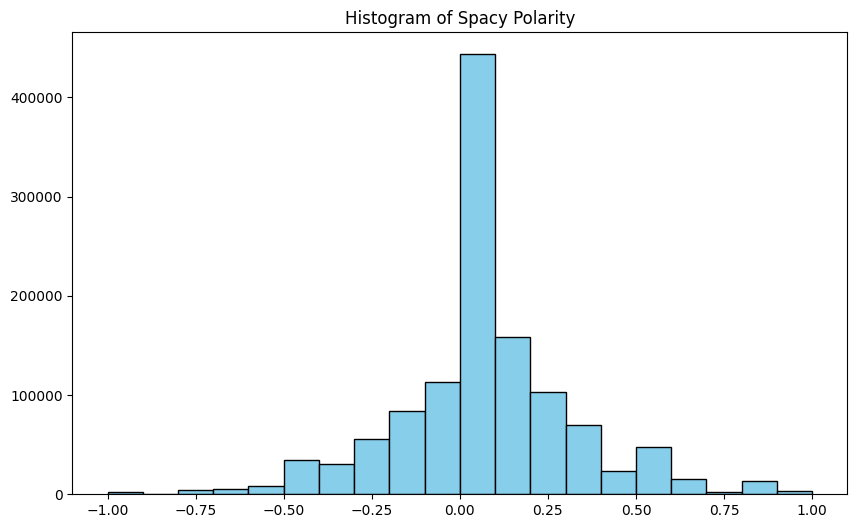

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(grouped_df['Polarity'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Spacy Polarity')
plt.show()

In [6]:
# Calculate the number of comments with polarity < -0.2
negative_polarity_count = (grouped_df['Polarity'] < -0.2).sum()

# Calculate the total number of comments
total_comments = len(grouped_df)

# Calculate the proportion
proportion_negative_polarity = negative_polarity_count / total_comments

# Display the result
print("Proportion of comments with polarity score less than -0.2:", proportion_negative_polarity)

Proportion of comments with polarity score less than -0.2: 0.07844658208257269


In [10]:
# Filter out comments with negative sentiment (polarity below -0.2)
negative_comments_df = grouped_df[grouped_df['Polarity'] < -0.2]

##NLP pipeline that includes filtering out irrelevant words such as swear words, useless words, toxic sg words that hold no semantic meaning besides toxicity, and words that relate to comments performed by reddit moderator bots

In [14]:
#filter out comments that may be performed by moderators:
bot_words = {'bot action', 'performed automatically', 'action performed', 'submission', 'automatically', 'moderator', 'link', 'bot', 'concern', 'please'}

In [15]:
# Filtering function
def filter_comments(df, bot_words):
    # Create a boolean mask for comments that do not contain any of the bot words
    mask = ~df['text'].str.lower().str.contains('|'.join(bot_words), na=False)
    # Return the filtered DataFrame
    return df[mask]

# Filter the DataFrame
df = filter_comments(negative_comments_df, bot_words)

In [17]:
# Initialise stop words list containing swear words and toxic words in sg context
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Read the words from 'swear_words.txt' and 'useless_words.txt'
with open('swear_words.txt', 'r') as f:
    swear_words = {line.strip() for line in f}

with open('sg_toxic.txt', 'r') as f:
    toxic_words = {line.strip() for line in f}

with open('useless_words.txt', 'r') as f:
    useless_words = {line.strip() for line in f}

# Update the stop_words set with swear words, useless words, and extra stopwords
stop_words.update(swear_words)
stop_words.update(toxic_words)
stop_words.update(useless_words)

[nltk_data] Downloading package stopwords to /Users/eushae-
[nltk_data]     anne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize

# Define text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):  # Check if text is a string
        return ''  # or handle accordingly, e.g., return None
    words = word_tokenize(text.lower())
    # Stopword removal and lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Remove punctuation and non-alphabetic tokens
    words = [word for word in words if word.isalpha()]
    return ' '.join(words)

df['processed_comment'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to /Users/eushae-
[nltk_data]     anne/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/xx/r8ly5z917sl1cyljnn77j7z00000gn/T/ipykernel_673/1324653882.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_comment'] = df['text'].apply(preprocess_text)


In [21]:
#Vectorize text using Tf-idf
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['processed_comment'])

##LDA for topic modelling

In [22]:
# 5. Apply LDA Topic Modeling
n_topics = 10  # Number of topics
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(X)

LatentDirichletAllocation(random_state=42)

In [23]:
# Function to print topics
def print_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx + 1}: ", [words[i] for i in topic.argsort()[-top_n:]])

In [24]:
# Print topics from toxic comments
print_topics(lda_model, vectorizer)

Topic 1:  ['work', 'think', 'time', 'need', 'good', 'go', 'want', 'get', 'one', 'people']
Topic 2:  ['much', 'day', 'im', 'go', 'want', 'people', 'time', 'singapore', 'get', 'one']
Topic 3:  ['year', 'go', 'singapore', 'want', 'time', 'know', 'one', 'get', 'think', 'people']
Topic 4:  ['know', 'go', 'im', 'time', 'see', 'need', 'one', 'think', 'get', 'people']
Topic 5:  ['year', 'go', 'know', 'need', 'think', 'good', 'one', 'time', 'get', 'people']
Topic 6:  ['need', 'singapore', 'good', 'think', 'im', 'get', 'time', 'year', 'one', 'people']
Topic 7:  ['know', 'good', 'make', 'singapore', 'time', 'get', 'one', 'think', 'gt', 'people']
Topic 8:  ['im', 'need', 'singapore', 'think', 'time', 'get', 'got', 'go', 'people', 'one']
Topic 9:  ['singapore', 'go', 'im', 'know', 'get', 'think', 'time', 'need', 'one', 'people']
Topic 10:  ['know', 'good', 'go', 'need', 'time', 'think', 'im', 'people', 'get', 'one']


In [25]:
#look at coherence scores
texts_preprocessed = df['processed_comment']

# Step 1: Create a Gensim Dictionary and Corpus
texts_tokenized = [text.split() for text in texts_preprocessed]
dictionary = Dictionary(texts_tokenized)
corpus = [dictionary.doc2bow(text) for text in texts_tokenized]

lda = lda_model
# Step 2: Get the topics from the LDA model
lda_topics = lda.components_
lda_topics_words = [[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in lda_topics]

# Step 3: Calculate Coherence Score
coherence_model_lda = CoherenceModel(topics = lda_topics_words,
                                     texts = texts_tokenized,
                                     dictionary = dictionary,
                                     coherence = 'c_v')

coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score for LDA Model: {coherence_lda}')

Coherence Score for LDA Model: 0.6614145864278014


## Tuning LDA Model by choosing the number of topics that give the highest coherence score

In [26]:
#hyperparameter tuning using grid search
n_topics_list = [3, 5, 10, 15, 20, 25]
coherence_scores = []

texts_tokenized = [text.split() for text in texts_preprocessed]

# It should take around 1 min for each iteration
for n_topics in tqdm(n_topics_list):

    lda = LatentDirichletAllocation(n_components = n_topics, random_state = 2024)
    lda.fit(X)
    lda_topics = lda.components_
    lda_topics_words = [[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in lda_topics]
    coherence_model_lda = CoherenceModel(topics = lda_topics_words,
                                         texts = texts_tokenized,
                                         dictionary = dictionary,
                                         coherence = 'c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"Number of topics: {n_topics} | Coherence Score: {coherence_lda}")
    coherence_scores.append(coherence_lda)

 17%|█▋        | 1/6 [01:16<06:24, 76.99s/it]

Number of topics: 3 | Coherence Score: 0.5999714574999532


 33%|███▎      | 2/6 [02:11<04:15, 63.88s/it]

Number of topics: 5 | Coherence Score: 0.6493739532338155


 50%|█████     | 3/6 [03:02<02:54, 58.04s/it]

Number of topics: 10 | Coherence Score: 0.6670148856674647


 67%|██████▋   | 4/6 [04:01<01:56, 58.32s/it]

Number of topics: 15 | Coherence Score: 0.6629350447593115


 83%|████████▎ | 5/6 [05:13<01:03, 63.23s/it]

Number of topics: 20 | Coherence Score: 0.6626511067570481


100%|██████████| 6/6 [06:35<00:00, 65.99s/it]

Number of topics: 25 | Coherence Score: 0.6669094560624665


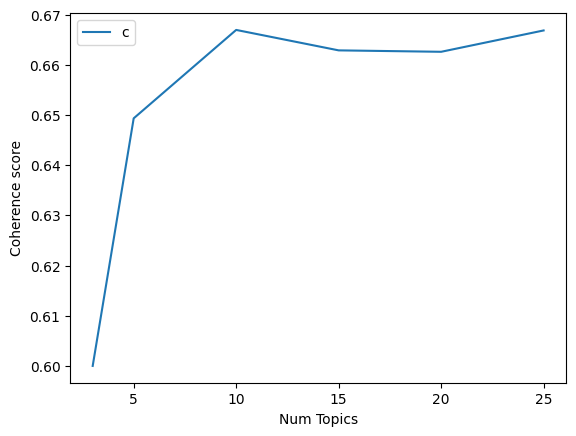

In [27]:
#plot coherence scores
import matplotlib.pyplot as plt
plt.plot(n_topics_list, coherence_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
#fit the model with the optimal number of topics (highest coherence score)
lda = LatentDirichletAllocation(n_components = 10, random_state = 2024)
lda.fit(X)
no_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
print_topics(lda_model, vectorizer)

Topic 1:  ['work', 'think', 'time', 'need', 'good', 'go', 'want', 'get', 'one', 'people']
Topic 2:  ['much', 'day', 'im', 'go', 'want', 'people', 'time', 'singapore', 'get', 'one']
Topic 3:  ['year', 'go', 'singapore', 'want', 'time', 'know', 'one', 'get', 'think', 'people']
Topic 4:  ['know', 'go', 'im', 'time', 'see', 'need', 'one', 'think', 'get', 'people']
Topic 5:  ['year', 'go', 'know', 'need', 'think', 'good', 'one', 'time', 'get', 'people']
Topic 6:  ['need', 'singapore', 'good', 'think', 'im', 'get', 'time', 'year', 'one', 'people']
Topic 7:  ['know', 'good', 'make', 'singapore', 'time', 'get', 'one', 'think', 'gt', 'people']
Topic 8:  ['im', 'need', 'singapore', 'think', 'time', 'get', 'got', 'go', 'people', 'one']
Topic 9:  ['singapore', 'go', 'im', 'know', 'get', 'think', 'time', 'need', 'one', 'people']
Topic 10:  ['know', 'good', 'go', 'need', 'time', 'think', 'im', 'people', 'get', 'one']


In [ ]:
# Group by year and month, then perform topic modeling
for (year, month), group in df.groupby(['year', 'month']):
    print(f"\nYear: {year}, Month: {month}")
    lda.fit(vectorizer.fit_transform(group['cleaned_text']))
    print_topics(lda, vectorizer.get_feature_names_out(), 10)


## NLP Using VADER for classifying negative comments



In [29]:
data_2022 = df[(df['timestamp'] >= '2022-01-01') & (df['timestamp'] < '2023-01-01')]

In [31]:
analyzer = SentimentIntensityAnalyzer()
data_2022['sentiment_vader'] = data_2022['text'].apply(lambda x: analyzer.polarity_scores(x)['neg'])

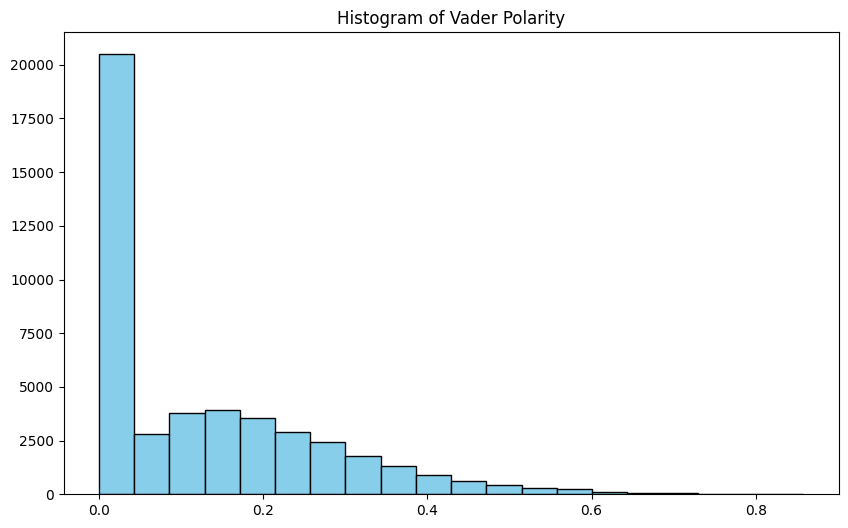

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(data_2022['sentiment_vader'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Vader Polarity')
plt.show()

In [37]:
# Calculate the number of comments with polarity > 0.2
negative_polarity_count = (data_2022['sentiment_vader']>0.2).sum()

# Calculate the total number of comments
total_comments = len(data_2022)

# Calculate the proportion
proportion_negative_polarity = negative_polarity_count / total_comments

# Display the result
print("Proportion of comments with negative polarity score more than 0.2:", proportion_negative_polarity)

Proportion of comments with negative polarity score more than 0.2: 0.2665776396155783


In [38]:
negative_comments = data_2022[data_2022['sentiment_vader'] > 0.2]
negative_comments.shape

(12177, 15)

## BERTopic for topic modelling

In [39]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(negative_comments['text'])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [40]:
topics_overview = topic_model.get_topic_info()
topics_overview

,Topic,Count,Name,Representation,Representative_Docs
0,-1,6641,-1_people_dont_one_get,"[people, dont, one, get, think, im, singapore,...",[wow didnt know many people hard time saying r...
1,0,486,0_food_chicken_eat_stall,"[food, chicken, eat, stall, taste, rice, fat, ...",[chickens shitty especially fast food hawker f...
2,1,299,1_gay_lgbt_religion_lgbtq,"[gay, lgbt, religion, lgbtq, religious, 377a, ...",[unfortunately history shown little done unles...
3,2,251,2_bus_driver_drivers_car,"[bus, driver, drivers, car, road, driving, bik...",[every bus driver careful though reckless howe...
4,3,166,3_court_assault_sexual_rape,"[court, assault, sexual, rape, lawyer, lawyers...",[probably matter legal strategy evidence prose...
...,...,...,...,...,...
119,118,11,118_criminals_crimes_prisons_prison,"[criminals, crimes, prisons, prison, consequen...",[criminal justice system isnt rooted rehabilit...
120,119,11,119_hardened_prison_imprisonment_old,"[hardened, prison, imprisonment, old, jail, re...",[offender sentenced life imprisonment served l...
121,120,11,120_mps_oppositions_elections_clowns,"[mps, oppositions, elections, clowns, lky, rul...",[end day people winner cannot win politics lea...
122,121,10,121_ads_ad_adverts_via,"[ads, ad, adverts, via, mewatchs, keywords, fi...","[omfg agree hate ads theyre everywhere, hate a..."


In [41]:
topic_model.get_topic_info().head(7).set_index('Topic')[['Count', 'Name', 'Representation']]

,Count,Name,Representation
Topic,,,
-1,6641,-1_people_dont_one_get,"[people, dont, one, get, think, im, singapore,..."
0,486,0_food_chicken_eat_stall,"[food, chicken, eat, stall, taste, rice, fat, ..."
1,299,1_gay_lgbt_religion_lgbtq,"[gay, lgbt, religion, lgbtq, religious, 377a, ..."
2,251,2_bus_driver_drivers_car,"[bus, driver, drivers, car, road, driving, bik..."
3,166,3_court_assault_sexual_rape,"[court, assault, sexual, rape, lawyer, lawyers..."
4,147,4_school_teachers_teacher_students,"[school, teachers, teacher, students, schools,..."
5,133,5_job_boss_work_company,"[job, boss, work, company, management, resign,..."


In [43]:
topic_model.visualize_barchart(top_n_topics = 8, n_words = 10)